In [1]:
from kinodata.data.dataset import KinodataDocked, _DATA, ComplexInformation

/opt/homebrew/Caskroom/miniforge/base/envs/kinodata3d/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = KinodataDocked()
df = dataset.df

Reading data frame from /Users/joschkagross/projects/kinodata-3D-affinity-prediction/data/raw/kinodata_docked_v2.sdf.gz...
Deduping data frame (current size: 121913)...
119713 complexes remain after deduplication.
Checking for missing pocket mol2 files...


100%|██████████| 3244/3244 [00:00<00:00, 212788.30it/s]


Adding pocket sequences...
(119713, 25)


100%|██████████| 119713/119713 [00:00<00:00, 5342704.53it/s]

Exiting with 3552 cached sequences.
(119713, 26)


In [3]:
complexes = ComplexInformation.from_raw(df, remove_hydrogen=True)

In [4]:
len(complexes)

119713

In [5]:
complexes = {
    complex.kinodata_ident: complex for complex in complexes
}

In [6]:
len(complexes)

119713

In [7]:
df = df.set_index("ident")

In [8]:
from pathlib import Path
import time
import torch

DATA = Path("data") / "remote_ig_attrbibutions"


def get_time(path: Path):
    # read a timestamp in the format YYYY-MM-DD_HH-MM-SS
    print(path)
    timestamp = path.name
    ptime = time.strptime(timestamp, "%Y-%m-%d_%H-%M-%S")
    print(ptime)
    return ptime


def load(path: Path | None = None):
    # use newest attributions if path is None
    if path is None:
        path = max(DATA.iterdir(), key=lambda p: get_time(p))

    print(f"The attributions are loaded from {path}")
    attrs = torch.load(path / "attrs.pt")
    deltas = torch.load(path / "deltas.pt")
    idents = torch.load(path / "idents.pt")
    return attrs, deltas, idents

In [9]:
attrs, deltas, idents = load()

data/remote_ig_attrbibutions/2024-08-28_12-02-43
time.struct_time(tm_year=2024, tm_mon=8, tm_mday=28, tm_hour=12, tm_min=2, tm_sec=43, tm_wday=2, tm_yday=241, tm_isdst=-1)
data/remote_ig_attrbibutions/2024-08-29_13-02-41
time.struct_time(tm_year=2024, tm_mon=8, tm_mday=29, tm_hour=13, tm_min=2, tm_sec=41, tm_wday=3, tm_yday=242, tm_isdst=-1)
data/remote_ig_attrbibutions/2024-08-28_12-18-22
time.struct_time(tm_year=2024, tm_mon=8, tm_mday=28, tm_hour=12, tm_min=18, tm_sec=22, tm_wday=2, tm_yday=241, tm_isdst=-1)
The attributions are loaded from data/remote_ig_attrbibutions/2024-08-29_13-02-41


In [10]:
from collections import defaultdict
from tqdm import tqdm

attr_df = defaultdict(list)
pbar = tqdm(total=len(attrs))
for attr, delta, ident in zip(attrs, deltas, idents):
    pbar.update(1)
    ident = ident.item()
    attr = attr.squeeze().numpy()
    complex_size = attr.shape[0]
    row = df.loc[ident]
    ligand_size = row["molecule"].GetNumHeavyAtoms()
    
    ligand_attr = attr[-ligand_size:].tolist()
    pocket_attr = attr[:-ligand_size].tolist()
    attr_df["ident"].extend([ident] * complex_size)
    
    attr_df["attr"].extend(ligand_attr)
    attr_df["type"].extend(["ligand"] * ligand_size)
    for atom in row["molecule"].GetAtoms():
        attr_df["atom"].append(atom.GetSymbol())
   
    attr_df["attr"].extend(pocket_attr) 
    attr_df["type"].extend(["pocket"] * (complex_size - ligand_size))
    cplx = complexes[ident]
    for atom in cplx.pocket.GetAtoms():
        attr_df["atom"].append(atom.GetSymbol())    

 99%|█████████▉| 3930/3950 [00:27<00:00, 347.64it/s]

In [11]:
import pandas as pd
attr_df = pd.DataFrame(attr_df)

In [12]:
import seaborn as sns
from matplotlib import pyplot as plt

(-0.5, 9.5)

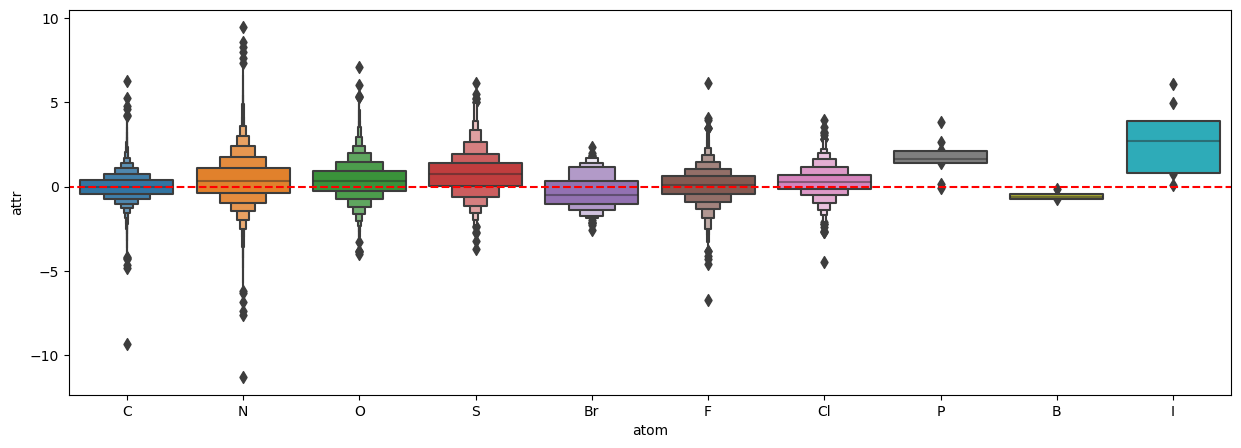

In [13]:
fig = plt.figure(figsize=(15, 5))
# add large axis for box plot
ax1 = fig.add_subplot(111)
sns.boxenplot(data=attr_df.query("type == 'ligand'"), x="atom", y="attr", ax=ax1)
xl = plt.xlim()
plt.plot((-1, 15), (0,0), 'r--')
plt.xlim(*xl)

(-0.5, 3.5)

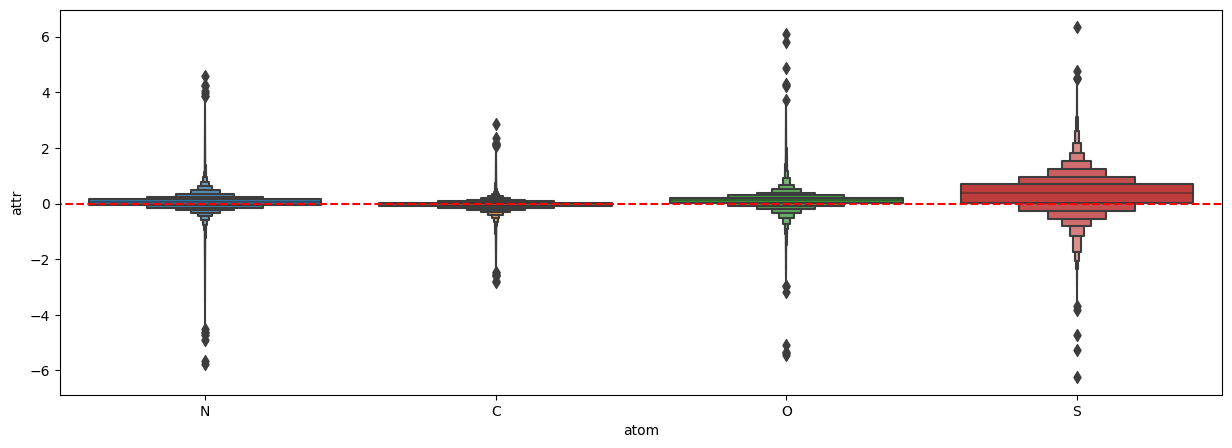

In [14]:
fig = plt.figure(figsize=(15, 5))
# add large axis for box plot
ax1 = fig.add_subplot(111)
sns.boxenplot(data=attr_df.query("type == 'pocket'"), x="atom", y="attr", ax=ax1)
xl = plt.xlim()
plt.plot((-1, 15), (0,0), 'r--')
plt.xlim(*xl)

In [15]:
attr_df["atom"].value_counts()

C     1798339
N      469837
O      462015
S       18023
F        2774
Cl        939
Br        183
P          10
I           7
B           4
Name: atom, dtype: int64

In [21]:
attr_df.groupby(["ident", "type"])["attr"].agg("max")

ident   type  
10      ligand    1.754369
        pocket    1.776717
26      ligand    2.007358
        pocket    1.508428
27      ligand    1.667351
                    ...   
119542  pocket    1.456821
119590  ligand    2.571836
        pocket    1.786083
119622  ligand    2.185760
        pocket    1.361934
Name: attr, Length: 7900, dtype: float64